# Preliminary #

In [1]:
%matplotlib inline

import numpy as np
import pickle
import os
import matplotlib.pyplot as plt

import sys
import time
from datetime import datetime

import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

In [2]:
def print_time(time_begin, time_end):
    FMT = '%H:%M:%S'
    td = (datetime.strptime(time_end[11:19], FMT) - datetime.strptime(time_begin[11:19], FMT)).seconds
    hr = (td//3600)
    min = (td - 3600*hr)//60
    sec = (td - 3600*hr - 60*min)
    return "{:2.0f}:{:2.0f}:{:2.0f}".format(hr,min,sec)

# Getting the Dataset #

In [3]:
'''LOADING DATASET'''
# Dataset located in folder : "./data"

compose = transforms.Compose([
                        transforms.ToTensor(), 
                        transforms.Normalize((.5, .5, .5), (.5, .5, .5))
                        ])

train_dataset = datasets.CIFAR10(root='./data', 
                                train=True, 
                                transform=compose,
                                download=True)

test_dataset = datasets.CIFAR10(root='./data', 
                               train=False, 
                               transform=compose)

Files already downloaded and verified


In [4]:
'''MAKING DATASET ITERABLE'''

batch_size = 100
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

train_batch_len = len(train_loader)
test_batch_len = len(test_loader)

print(train_batch_len)
print(test_batch_len)

500
100


Ship


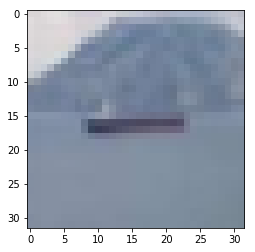

In [5]:
def print_img(x,y):
    '''
    Prints the image at the given index from the train dataset with its associated label.
    '''
    
    img = np.array(x).reshape((32,32,3), order='F')
    #img = np.transpose(img, (1,0,2))
    
    label_dict = {0:"Airplane", 
                      1:"Automobile", 
                      2:"Bird", 
                      3:"Cat", 
                      4:"Deer", 
                      5:"Dog", 
                      6:"Frog", 
                      7:"Horse", 
                      8:"Ship", 
                      9:"Truck"
                     }
        
    label = label_dict[y]
    print(label)              
    
    imgplot = plt.imshow(img)
    plt.show()

# Printing a sample image
ind = 2333
print_img(train_dataset.train_data[ind], train_dataset.train_labels[ind])

# Defining the Discriminator and Generator #

In [6]:
class Discriminator(torch.nn.Module):
    """
    A six hidden-layer discriminative neural network
    """
    def __init__(self):
        super(Discriminator, self).__init__()
        
        #[03,32,32 -> 32,16,16]
        self.nn0 = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1,),
            nn.LeakyReLU(0.2),
        )
        
        #[32,16,16 -> 64,13,13]
        self.nn1 = nn.Sequential(            
            nn.Conv2d(32, 64, 4, 1, 0),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
        )
        
        #[64,13,13 -> 128,10,10]
        self.nn2 = nn.Sequential(
            nn.Conv2d(64, 128, 4, 1, 0),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        
        #[128,10,10 -> 256,7,7]
        self.nn3 = nn.Sequential(
            nn.Conv2d(128, 256, 4, 1, 0),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
        )
        
        #[256,7,7 -> 512,4,4]
        self.nn4 = nn.Sequential(
            nn.Conv2d(256, 512, 4, 1, 0),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
        )
        
        self.out = nn.Sequential(
            nn.Linear(512*4*4, 1),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        #print("d-1 ",x.shape)
        
        x = self.nn0(x)
        #print("d0 ",x.shape)
        
        #print("d1 ",x.shape)
        
        x = self.nn1(x)
        #print("d2 ",x.shape)
        
        x = self.nn2(x)
        #print("d3 ",x.shape)
        
        x = self.nn3(x)
        #print("d4 ",x.shape)
        
        x = self.nn4(x)
        #print("d5 ",x.shape)
        
        x = x.view(x.shape[0], 512*4*4)
        x = self.out(x)
        return x
    
discriminator = Discriminator().cuda()

In [7]:
class Generator(torch.nn.Module):
    """
    A six hidden-layer generative neural network
    """
    def __init__(self):
        super(Generator, self).__init__()
        
        self.nn0 = nn.Sequential(
            nn.Linear(100, 512*4*4),
            nn.Sigmoid(),
        )
        
        self.nn1 = nn.Sequential( 
            nn.ConvTranspose2d(512, 256, 4, 1, 0),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        
        self.nn2 = nn.Sequential( 
            nn.ConvTranspose2d(256, 128, 4, 1, 0),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        
        self.nn3 = nn.Sequential( 
            nn.ConvTranspose2d(128, 64, 4, 1, 0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        
        self.nn4 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, 1, 0),
            nn.BatchNorm2d(32),
            nn.ReLU(),
        )
        
        self.out = nn.Sequential(
            nn.ConvTranspose2d(32, 3, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.nn0(x)
        #print("g0 ",x.shape)
        
        x = x.view(x.shape[0], 512, 4, 4)
        #print("g1 ",x.shape)
        
        x = self.nn1(x)
        #print("g2 ",x.shape)
        
        x = self.nn2(x)
        #print("g3 ",x.shape)
        
        x = self.nn3(x)
        #print("g4 ",x.shape)
        
        x = self.nn4(x)
        #print("g5 ",x.shape)
        
        x = self.out(x)
        return x
    
generator = Generator().cuda()

# Some Helper Functions #

In [8]:
def get_noise(size):
    '''
    Generates a 1-d vector of gaussian sampled random values to be fed to the generator
    '''
    n = Variable(torch.randn(size,100)).cuda()
    return n

def get_noisy_ones(shape):
    '''
    Generates a 1-d vector of values uniformly sampled between [0.7,1.0) of given size
    '''
    
    bias_val = 0.1
    data = Variable((bias_val * torch.rand(shape) + (1-bias_val))).cuda()
    
    return data

def get_noisy_zeros(shape):
    '''
    Generates a 1-d vector of values uniformly sampled between [0.0,0.3) of given size
    '''
                    
    bias_val = 0.1;
    data = Variable(((1-bias_val) * torch.rand(shape))).cuda()
    
    return data

In [36]:
def gen_image():
    '''
    Provides the Generator with some noise and prints the resultant image.
    '''
    img = generator.forward(get_noise(N)).detach().cpu()[0]
    img = (img + 1)/2
    img = np.transpose(img,(1,2,0))
    #img = np.array(img).reshape((32,32,3), order='F')
    plt.imshow(img)
    plt.savefig('final.png', dpi=100)
    plt.show()

# Deciding the Architecture #

In [10]:
d_optimizer = optim.SGD(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

In [11]:
loss = nn.BCELoss()

In [12]:
def train_discriminator(optimizer, X_train_real):
    
    # Generate real data
    real_data = Variable(X_train_real)   
    
    # Generate fake data 
    N = real_data.size(0)
    fake_data = generator(get_noise(N)).detach()
        
    # Reset gradients
    optimizer.zero_grad()
    
    # Train on Real Data
    prediction_real = discriminator(real_data)
    
    # Calculate error and backpropagate
    error_real = loss(prediction_real, get_noisy_ones(prediction_real.shape))
    error_real.backward()

    # Train on Fake Data
    prediction_fake = discriminator(fake_data)
    
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, get_noisy_zeros(prediction_fake.shape))
    error_fake.backward()
    
    # Update weights with gradients
    optimizer.step()
    
    # Return error and predictions for real and fake inputs
    return error_real + error_fake, prediction_real, prediction_fake

In [13]:
def train_generator(optimizer, N):
    
    # Generate fake data
    fake_data = generator(get_noise(N))
    
    # Reset gradients
    optimizer.zero_grad()
    
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    
    #Calculate error and backpropagate
    error = loss(prediction, get_noisy_ones(N))
    error.backward()
    
    # Update weights with gradients
    optimizer.step()
    
    # Return error
    return error

# Training the Net #

In [14]:
iteration = 0

iter_list = []
d_error_list = []
g_error_list = []

In [15]:
# Total number of epochs to train
num_iterations = 20

In [ ]:
print("Beginning Training ...")
iter_total = num_iterations + iteration

for i in range(num_iterations):
    time_begin = time.asctime()
    iteration += 1
    print("------------------------------------")  
    print("Iteration : {}/{}".format(iteration,iter_total))
    
    tl_len = len(train_loader);
    for batch_num, (X_train_real,Y_train_real) in enumerate(train_loader):
        
        # Moving the data to GPU
        X_train_real = X_train_real.cuda()
        Y_train_real = Y_train_real.cuda()
                
        # Train Discriminator
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer, X_train_real)
        #d_error = torch.Tensor([-1])
        
        # Train Generator
        N = X_train_real.size(0)
        g_error = train_generator(g_optimizer, N)
        #g_error = torch.Tensor([-1])
        
        # Update progress
        if(batch_num%(tl_len/100)) == 0 :
            sys.stdout.write("Progress : {:.0f}% \r".format(batch_num/(tl_len/100)))
            sys.stdout.flush()
        
    # Append Error values to Monitering lists
    iter_list.append(iteration)
    d_error_list.append(d_error.item())
    g_error_list.append(g_error.item())

    # Report Error after iteration
    print("Discriminator Error : {:.10f}".format(d_error))
    print("Generator Error     : {:.10f}".format(g_error))
    
    # Report time taken for iteration
    time_end = time.asctime()
    print("Total train time    :", print_time(time_begin, time_end))
    
    # Generate a sample image image
    gen_image()
    print("------------------------------------") 

print("Done.")

In [ ]:
### Checking the Predictions ###

print("Mean Predictions : ")
print("Real : ",d_pred_real.mean().item())
print("Fake : ",d_pred_fake.mean().item())

In [ ]:
print(iter_list[-5:])
print(d_error_list[-5:])
print(g_error_list[-5:])

# Performance Analysis #

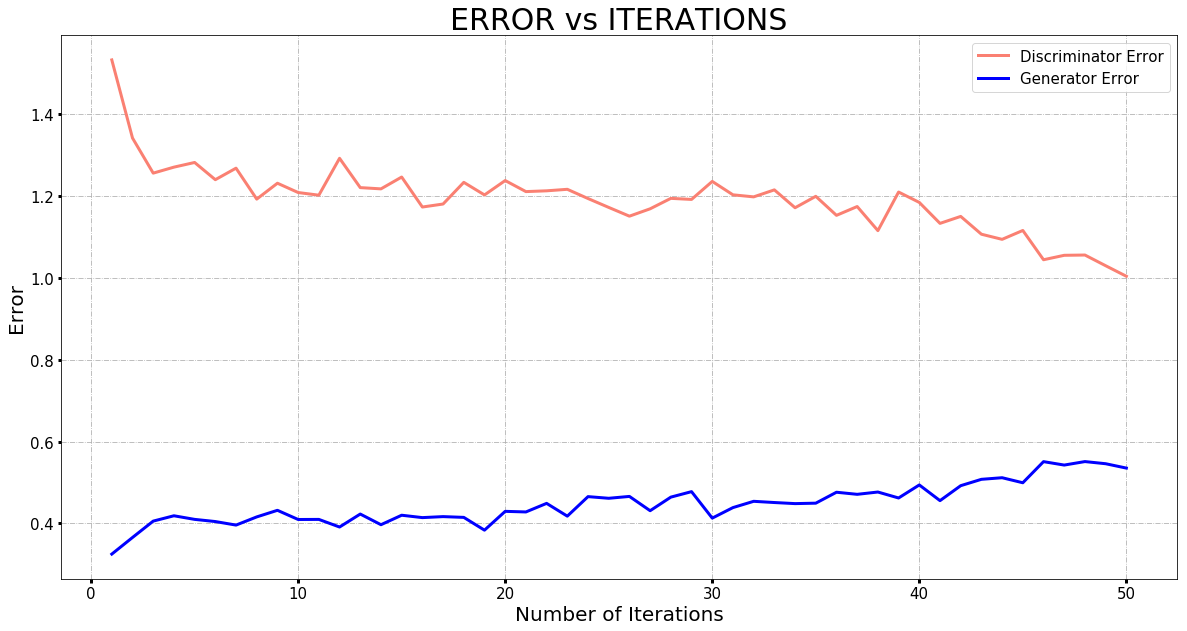

In [38]:
'''PLOTTTING THE ERROR GRAPH'''

plt.figure(figsize=[20,10])

plt.plot(iter_list, d_error_list, '-', lw=3, c='salmon', label='Discriminator Error')
plt.plot(iter_list, g_error_list, '-', lw=3, c='blue', label='Generator Error')

plt.title('ERROR vs ITERATIONS', size='30')
plt.xlabel('Number of Iterations', size='20')
plt.ylabel('Error', size='20')

plt.grid(True, linestyle='-.',)
plt.tick_params(labelcolor='k', labelsize='15', width=3)

plt.legend(fontsize='15')

fig1 = plt.gcf()
plt.show()

fig1.savefig('cost_vs_iterations.png', dpi=100)

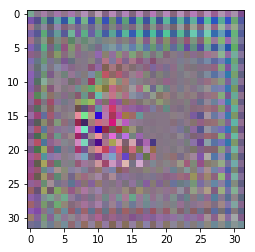

In [39]:
### Checking the Sample image Generated ###

gen_image()

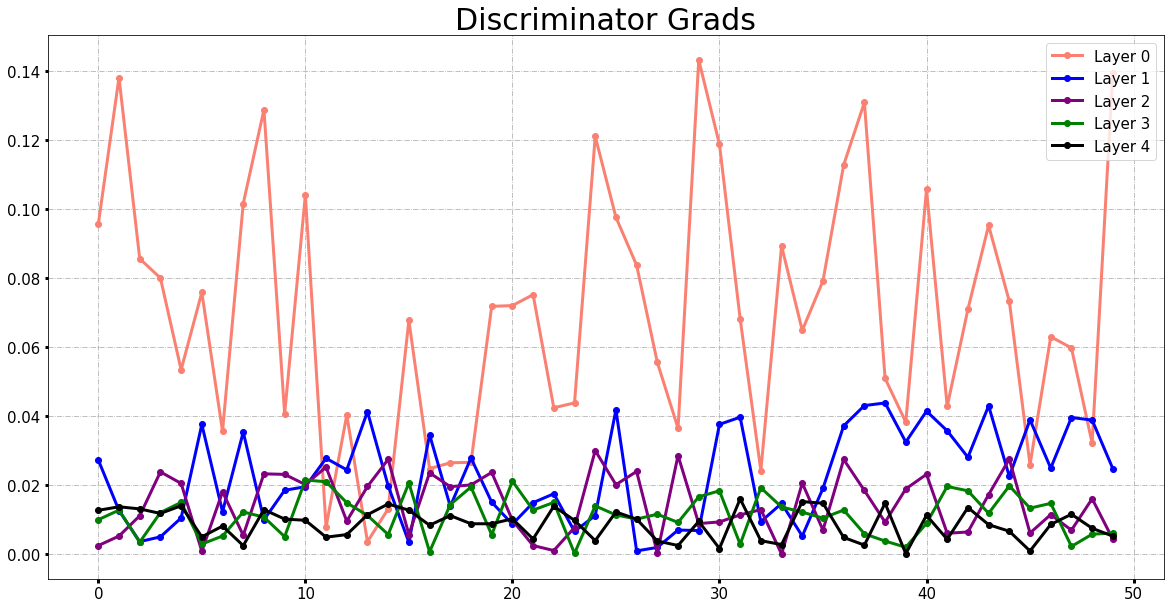

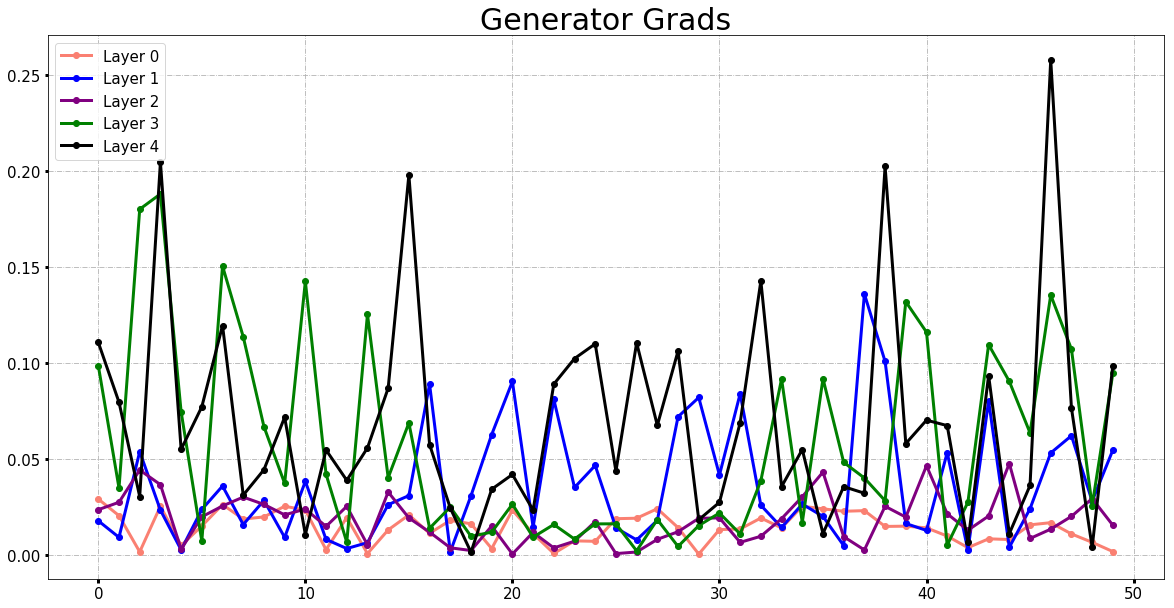

In [23]:
### Plotting the Gradients ###

def plot_gradients(net):
    if(net=="discriminator"):
        a = list(discriminator.nn0.parameters())[0]
        b = list(discriminator.nn1.parameters())[0]
        c = list(discriminator.nn2.parameters())[0]
        d = list(discriminator.nn3.parameters())[0]
        e = list(discriminator.nn4.parameters())[0]
        
    if(net=="generator"):
        a = list(generator.nn0.parameters())[0]
        b = list(generator.nn1.parameters())[0]
        c = list(generator.nn2.parameters())[0]
        d = list(generator.nn3.parameters())[0]
        e = list(generator.nn4.parameters())[0]

            
    a = a.reshape(-1,1)[:50]
    a = np.abs(np.array(a.cpu().detach()))
    b = b.reshape(-1,1)[:50]
    b = np.abs(np.array(b.cpu().detach()))
    c = c.reshape(-1,1)[:50]
    c = np.abs(np.array(c.cpu().detach()))
    d = d.reshape(-1,1)[:50]
    d = np.abs(np.array(d.cpu().detach()))
    e = e.reshape(-1,1)[:50]
    e = np.abs(np.array(e.cpu().detach()))
    z = np.array(list(range(len(a)))).reshape(-1,1)

    plt.figure(figsize=(20,10))
    
    if(net=="discriminator") : plt.title('Discriminator Grads', size='30')
    if(net=="generator") : plt.title('Generator Grads', size='30')
    
    plt.plot(z,a, '-o', lw=3, c='salmon',label='Layer 0')
    plt.plot(z,b, '-o', lw=3, c='blue',label='Layer 1')
    plt.plot(z,c, '-o', lw=3, c='purple',label='Layer 2')
    plt.plot(z,d, '-o', lw=3, c='green',label='Layer 3')
    plt.plot(z,e, '-o', lw=3, c='black',label='Layer 4')

    plt.grid(True, linestyle='-.',)
    plt.tick_params(labelcolor='k', labelsize='15', width=3)
    plt.legend(fontsize='15')

    plt.show()

plot_gradients("discriminator")
plot_gradients("generator")

# Archiving #

In [ ]:
### Saving the Model ###

torch.save(generator.state_dict(), "./generator.pth")
torch.save(discriminator.state_dict(), "./discriminator.pth")

monitering_lists = [iter_list, g_error_list, d_error_list]
with open("./monitering_lists.txt", "wb") as fp:
            pickle.dump(monitering_lists, fp)

In [21]:
### Loading the Model ###

generator = Generator()
generator.load_state_dict(torch.load("./generator.pth"))
generator.eval()
generator.cuda()

discriminator = Discriminator()
discriminator.load_state_dict(torch.load("./discriminator.pth"))
discriminator.eval()
discriminator.cuda()

with open("./monitering_lists.txt", "rb") as fp:
            monitering_lists = pickle.load(fp)
        
iter_list, g_error_list, d_error_list = monitering_lists
iteration = iter_list[-1]
N = 100